# Performance Tests of Matrix Multiply Algorithms

The point of this notebook is to test different matrix-multiply algorithms for doing the vis-cpu algorithm's $V = ZZ^\dagger$. In this notebook, we don't care about _how_ we got $Z$, only that it is complex-valued, and its shape is supposed to be $N_{\rm feed} N_{\rm ant} \times N_{\rm ax} N_{\rm src}$, which is generally _very_ non-square. 

We define a number of methods that compute $V$, and test their performance on different shapes of $Z$.

In [145]:
from scipy.linalg import blas
import numpy as np
import matplotlib.pyplot as plt
import pycuda.autoinit
from pycuda import cumath as cm
from pycuda import driver, gpuarray
from skcuda.cublas import (
    cublasCreate,
    cublasDestroy,
    cublasZgemm,
    cublasZherk,
    cublasZdotc
)
import jax.numpy as jnp
import arrayfire
import time
from dataclasses import dataclass, asdict
import yaml
from pathlib import Path
import numba

In [2]:
h = cublasCreate()

In [99]:
repeats: int = 1
rerun: bool = False
precision: int = 2
nants_redundant: int = 350

## Plotting Functions

In [77]:
def plot_timings(timings: dict[str, dict[tuple[int, int], "TimeResult"]]):
    fig, ax = plt.subplots(2, max(len(nants), len(nsrcs)), figsize=(15, 8), constrained_layout=True)

    for i, (nside, nsrc) in enumerate(zip(nsides, nsrcs)):
        for j, (method, results) in enumerate(timings.items()):
            ax[0, i].plot(nants, [results[(n, nside)].best for n in nants], color=f'C{j}', label=method)
            
        ax[0, i].set_title(f"Nside={nside}")
        ax[0, i].set_xlabel("Nants x Nfeeds")
        ax[0, 0].set_ylabel("Time [sec]")
        ax[0, i].plot(nants, np.array(nants) * (results[(np.max(nants), nside)].best/np.max(nants)), ls='--', color='k')
        
        ax[0, i].set_xscale('log')
        ax[0, i].set_yscale('log')
    
    for j in range(i+1, ax.shape[1]):
        ax[0, j].axis('off')
        
        
    for i, nant in enumerate(nants):
        for j, (method, results) in enumerate(timings.items()):
            ax[1, i].plot(nsrcs, [results[(nant, n)].best for n in nsides], color=f'C{j}')

        ax[1,i].set_title(f"Nant x Nfeed={nant}")
        ax[1,i].set_xlabel("nsrc")
        ax[1, i].set_xscale('log')
        ax[1, i].set_yscale('log')
        ax[1, i].plot(nsrcs, np.array(nsrcs) * (results[(nant, np.max(nsides))].best/np.max(nsrcs)), ls='--', color='k')
    
    ax[0,0].legend(frameon=False, ncols=2)
    return fig, ax

## Make Test Arrays

In [11]:
def getz(shape):
    return (
        np.random.random(shape, dtype=np.float32 if precision==1 else float) + 
        np.random.random(shape, dtype=np.float32 if precision==1 else float)*1j
    )

# Note that "nants" here represents Nants * Nfeed, which is why we 
# go to double the number of ants that HERA has.
nants = (100, 200, 400, 700)

nsides = [32, 64, 128, 256]
nsrcs = [2 * 12 * nside**2 for nside in nsides]

z = {}
for nant in nants:
    for nsrc, nside in zip(nsrcs, nsides):
        z[(nant, nside)] = getz((nant, nsrc))

Use the smallest array as a test

In [13]:
z0 = z[(nants[0], nsides[0])]
v0 = np.dot(z0, z0.conj().T)

## Scaffolding for methods

In [124]:
class Solver:
    def __init__(self, z: np.ndarray):
        self.z = z
        
    def setup(self):
        pass
    
    def compute(self):
        pass
    
    def __call__(self):
        self.setup()
        return self.compute()
    
    @classmethod
    def test(cls, rtol=1e-5, atol=1e-5):
        obj = cls(z0)
        result = obj()
        np.testing.assert_allclose(result, v0, rtol=rtol, atol=atol)
        
class RedundantSolver:
    def __init__(self, z: np.ndarray, pairs: np.ndarray):
        self.z = z
        self.pairs = pairs
        
    def setup(self):
        pass
    
    def compute(self):
        pass
    
    def __call__(self):
        self.setup()
        return self.compute()
    
    @classmethod
    def test(cls, rtol=1e-5, atol=1e-5):
        # All the pairs.
        nant = z0.shape[0]
        pairs = np.array([(a, b) for a in range(nant) for b in range(nant)])
        obj = cls(z0, pairs)
        result = obj()
        np.testing.assert_allclose(result.reshape((nant, nant)), v0, rtol=rtol, atol=atol)
    

In [131]:
@dataclass
class TimeResult:
    times: list[float]
    n: int
    
    @property
    def best(self):
        return np.min(self.times)
    
    @property
    def mean(self):
        return np.mean(self.times)
    
    @property
    def repeats(self):
        return len(self.times)
    
    @property
    def std(self):
        return np.std(self.times)
    
def get_timing(sln, repeats: int = repeats) -> float:
    sln.setup()
    
    # this timing is not even used because it could contain
    # caching and other overhead.
    t0 = time.time()
    sln.compute()
    t1 = time.time() - t0


    # Need to do it at least twice to check if the time comes down.
    t0 = time.time()
    sln.compute()
    t2 = time.time() - t0

    n = int(2 / t2) + 1
    
    if n == 1:
        times = [t2]
        
        for _ in range(repeats - 1):
            t0 = time.time()
            sln.compute()
            times.append(time.time() - t0)
            
    else:
        times = []
        for _ in range(repeats):
            t0 = time.time()
            for _ in range(n):
                sln.compute()
            times.append((time.time() - t0)/n)

    return TimeResult(times, n)

def get_timings(solver, repeats: int=repeats, rerun: bool = rerun) -> dict[tuple[int, int], float]:
    out = {}
    
    # First, test the solver.
    solver.test()
    
    for size, zz in z.items():
        print(size, end=': ')
        
        pth = Path(f"{solver.__name__}_{size[0]}x{size[1]}.yaml")
        if not rerun and pth.exists():
            with open(pth, 'r') as fl:
                o = out[size] = TimeResult(**yaml.safe_load(fl))
        else:
            sln = solver(zz)
            
            o = out[size] = get_timing(sln)
            del sln  # Ensure memory is freed.
            
        print(f"{o.mean:1.3e}s ± {o.std:1.3e}s [{o.repeats} loops of {o.n}]")
        
        # Cache it
        with open(pth, 'w') as fl:
            yaml.dump(asdict(o), fl)
            
    return out

def get_timings_red(solver, repeats: int=repeats, rerun: bool = rerun) -> dict[tuple[int, int], float]:
    out = {}
    
    # First, test the solver.
    solver.test()
    
    for redfrac, p in pairs.items():
        for (nside, nsrc) in zip(nsides, nsrcs):
            size = (redfrac, nside)
            print(size, end=': ')
        
            pth = Path(f"{solver.__name__}_{size[0]}x{size[1]}.yaml")
            if not rerun and pth.exists():
                with open(pth, 'r') as fl:
                    o = out[size] = TimeResult(**yaml.safe_load(fl))
            else:
                sln = solver(z[(nants_redundant*2, nside)], p)

                o = out[size] = get_timing(sln)
                del sln  # Ensure memory is freed.

            print(f"{o.mean:1.3e}s ± {o.std:1.3e}s [{o.repeats} loops of {o.n}]")

            # Cache it
            with open(pth, 'w') as fl:
                yaml.dump(asdict(o), fl)
            
    return out

In [51]:
timings = {}

## Full Dot-Product Methods

### CPU

#### np.dot

In [52]:
class NpDot(Solver):
    def compute(self):
        return np.dot(self.z, self.z.conj().T)

In [80]:
timings['np.dot'] = get_timings(NpDot)

(100, 32): 4.537e-02s ± 0.000e+00s [1 loops of 38]
(100, 64): 1.921e-01s ± 0.000e+00s [1 loops of 7]
(100, 128): 5.643e-01s ± 0.000e+00s [1 loops of 3]
(100, 256): 2.189e+00s ± 0.000e+00s [1 loops of 1]
(200, 32): 9.882e-02s ± 0.000e+00s [1 loops of 22]
(200, 64): 3.205e-01s ± 0.000e+00s [1 loops of 6]
(200, 128): 1.062e+00s ± 0.000e+00s [1 loops of 2]
(200, 256): 4.268e+00s ± 0.000e+00s [1 loops of 1]
(400, 32): 1.990e-01s ± 0.000e+00s [1 loops of 10]
(400, 64): 7.316e-01s ± 0.000e+00s [1 loops of 3]
(400, 128): 2.385e+00s ± 0.000e+00s [1 loops of 1]
(400, 256): 1.016e+01s ± 0.000e+00s [1 loops of 1]
(700, 32): 4.552e-01s ± 0.000e+00s [1 loops of 5]
(700, 64): 1.916e+00s ± 0.000e+00s [1 loops of 2]
(700, 128): 5.792e+00s ± 0.000e+00s [1 loops of 1]
(700, 256): 2.275e+01s ± 0.000e+00s [1 loops of 1]


#### zgemm

In [72]:
class NpZgemm(Solver):
    def compute(self):
        return blas.zgemm(alpha=1, a=self.z, b=self.z.conj(), trans_b=True)

In [81]:
timings['np.zgemm'] = get_timings(NpZgemm)

(100, 32): 1.316e-01s ± 0.000e+00s [1 loops of 17]
(100, 64): 3.535e-01s ± 0.000e+00s [1 loops of 6]
(100, 128): 1.255e+00s ± 0.000e+00s [1 loops of 2]
(100, 256): 4.666e+00s ± 0.000e+00s [1 loops of 1]
(200, 32): 2.316e-01s ± 0.000e+00s [1 loops of 10]
(200, 64): 7.361e-01s ± 0.000e+00s [1 loops of 3]
(200, 128): 2.506e+00s ± 0.000e+00s [1 loops of 1]
(200, 256): 1.010e+01s ± 0.000e+00s [1 loops of 1]
(400, 32): 4.873e-01s ± 0.000e+00s [1 loops of 5]
(400, 64): 1.897e+00s ± 0.000e+00s [1 loops of 2]
(400, 128): 7.242e+00s ± 0.000e+00s [1 loops of 1]
(400, 256): 3.057e+01s ± 0.000e+00s [1 loops of 1]
(700, 32): 9.058e-01s ± 0.000e+00s [1 loops of 3]
(700, 64): 3.519e+00s ± 0.000e+00s [1 loops of 1]
(700, 128): 1.344e+01s ± 0.000e+00s [1 loops of 1]
(700, 256): 5.758e+01s ± 0.000e+00s [1 loops of 1]


#### zherk

In [ ]:
class NpZherk(Solver):
    def compute(self):
        return blas.zherk(alpha=1, a=self.z)

In [ ]:
timings['np.zherk'] = get_timings(NpZherk)

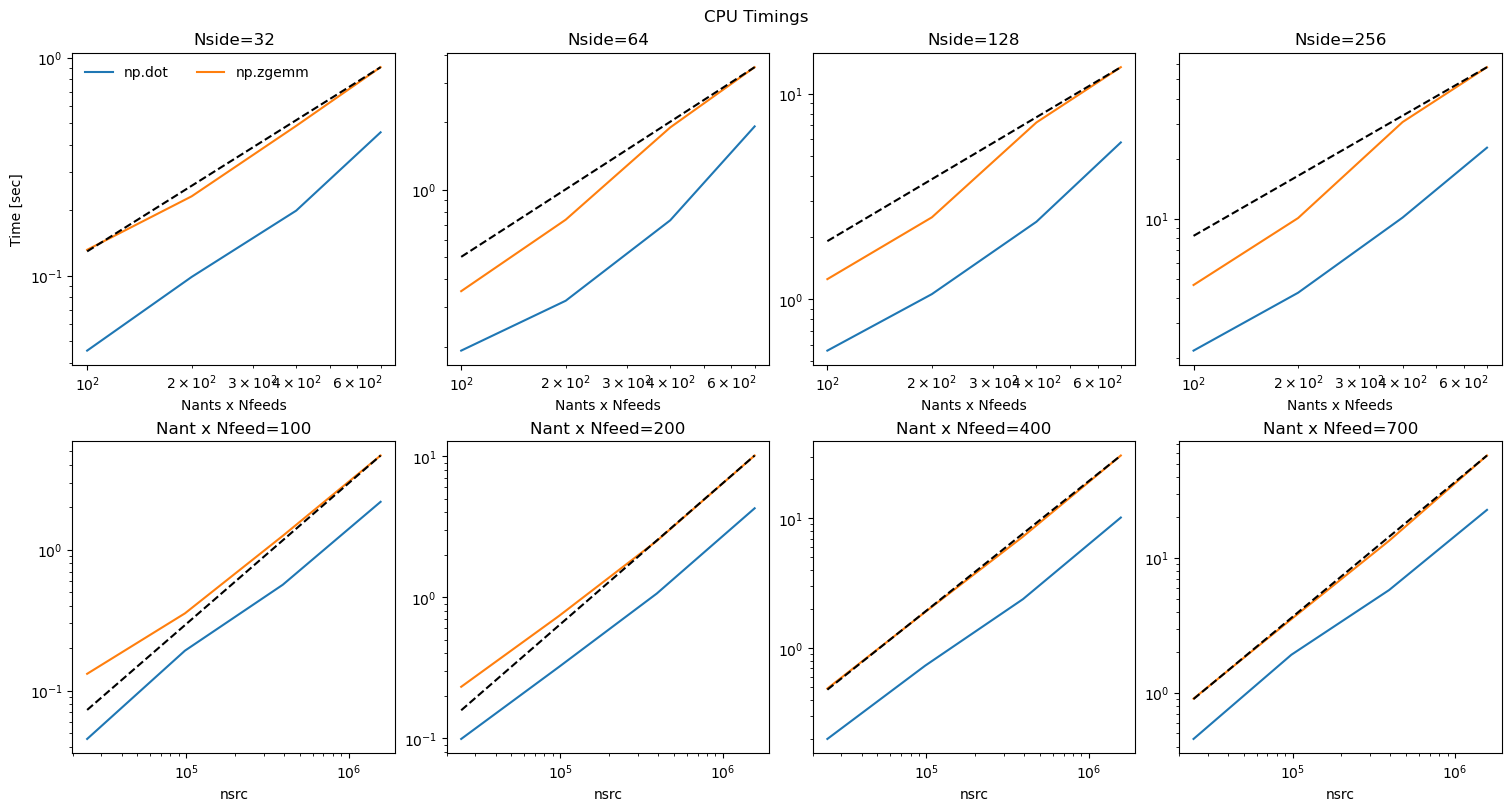

In [82]:
fig, ax = plot_timings(timings)
fig.suptitle("CPU Timings");

### CuBLAS

#### cublas.zgemm

In [86]:
class CuBLASZgemm(Solver):
    def setup(self):
        self.z = gpuarray.to_gpu(self.z)
        nant = self.z.shape[0]
        self.out = gpuarray.empty(shape=(nant, nant), dtype=complex)

    def compute(self):
        nant, nsrc = self.z.shape

        cublasZgemm(
            h,
            "c",  # conjugate transpose for first (remember fortran order)
            "n",  # no transpose for second.
            nant,
            nant,
            nsrc,
            1.0,
            self.z.gpudata,
            nsrc,
            self.z.gpudata,
            nsrc,
            0.0,
            self.out.gpudata,
            nant,
        )
        return self.out.get()

In [87]:
timings['cublas.zgemm'] = get_timings(CuBLASZgemm)

(100, 32): 1.597e-02s ± 0.000e+00s [1 loops of 107]
(100, 64): 6.254e-02s ± 0.000e+00s [1 loops of 32]
(100, 128): 2.486e-01s ± 0.000e+00s [1 loops of 9]
(100, 256): 9.924e-01s ± 0.000e+00s [1 loops of 3]
(200, 32): 4.867e-02s ± 0.000e+00s [1 loops of 40]
(200, 64): 1.912e-01s ± 0.000e+00s [1 loops of 11]
(200, 128): 7.617e-01s ± 0.000e+00s [1 loops of 3]
(200, 256): 3.045e+00s ± 0.000e+00s [1 loops of 1]
(400, 32): 1.869e-01s ± 0.000e+00s [1 loops of 11]
(400, 64): 7.467e-01s ± 0.000e+00s [1 loops of 3]
(400, 128): 2.987e+00s ± 0.000e+00s [1 loops of 1]
(400, 256): 1.199e+01s ± 0.000e+00s [1 loops of 1]
(700, 32): 5.496e-01s ± 0.000e+00s [1 loops of 4]
(700, 64): 2.196e+00s ± 0.000e+00s [1 loops of 1]
(700, 128): 8.790e+00s ± 0.000e+00s [1 loops of 1]
(700, 256): 

MemoryError: cuMemAlloc failed: out of memory

#### cublas.zherk

In [ ]:
class CuBLASZherk(CuBLASZgemm):
    def compute(self):
        nant, nsrc = self.z.shape

        cublasZherk(
            h,
            uplo="L",
            trans=trans,
            n=nant,
            k=nsrc,
            alpha=1.0,
            A=self.z.gpudata,
            lda=nsrc,
            beta=0.0,
            C=self.out.gpudata,
            ldc=nant
        )
        return out.get()

In [ ]:
timings['cublas.zherk'] = get_timings(CuBLASZherk)

### JAX

In [138]:
import jax
from jax import config

if precision==2:
    config.update('jax_enable_x64',True)

In [89]:
class JAXdot(Solver):
    def setup(self):
        self.z = jax.device_put(self.z)
    
    def compute(self):        
        out = jnp.dot(self.z, self.z.T.conj(), precision=jax.lax.Precision.HIGHEST)
        return jax.device_get(out)

In [ ]:
timings['jax.dot'] = get_timings(JAXdot)

### ArrayFire

There's something weird about how arrayfire stores arrays in memory so that you NEED to use the transpose shape for the array to make sense, but then of course if you go BACK to numpy arrays on cpu, they're the transpose of the original. I've tested passing in pre-transposed data and computing the GEMM and it takes essentially the same amount of time.

In [97]:
class ArrayFireGemm(Solver):
    def setup(self):
        self.out = arrayfire.Array(dtype=self.z.dtype.char, dims=(self.z.shape[0], self.z.shape[0]))
        self.z = arrayfire.from_ndarray(self.z)
        
    def compute(self):
        return arrayfire.blas.gemm(
            self.z, self.z, lhs_opts=arrayfire.MATPROP.NONE, rhs_opts=arrayfire.MATPROP.CTRANS, C=self.out
        )

In [ ]:
timings['af.gemm'] = get_timings(ArrayFireGemm)

## Redundant Baseline Methods

Say that we have different subsets of baselines that should actually be "used". Let's see how long different methods take there...

In [100]:
allpairs = np.array([(0,0)] + [(a, b) for a in range(nants_redundant*2) for b in range(a+1, nants_redundant*2)])

pairs = {}
pairfracs = [3, 10, 25, 50]

for pc in pairfracs:
    pairs[pc] = allpairs[np.sort(np.random.choice(np.arange(len(allpairs)), size=int(len(allpairs)*pc/100), replace=False))]

In [154]:
def plot_timings_reds(red_timings: dict[str, dict[tuple[int, int], TimeResult]], 
                      timings: dict[str, dict[tuple[int, int], TimeResult]]):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout=True)
        
    for j, (method, results) in enumerate(timings.items()):
        ax.plot(nsrcs, [results[(nants_redundant*2, n)].best for n in nsides], color=f'C{j}', label=method)
        
    for j, (method, results) in enumerate(red_timings.items(), start=len(timings)):
        for k, frac in enumerate(pairfracs):
            ax.plot(
                nsrcs, [results[(frac, n)].best for n in nsides], 
                color=f'C{j%10}', ls=[':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))][k], 
                label=f"{method} ({frac}% red.)"
            )
        
    ax.set_title(f"Nant x Nfeed={nant}")
    ax.set_xlabel("nsrc")
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.plot(nsrcs, np.array(nsrcs) * (results[(350, np.max(nsrcs))].best/np.max(nsrcs)), ls='--', color='k')

    ax.legend(frameon=False, ncols=3)
    return fig, ax

In [142]:
timings_reds = {}

### Custom Kernel

In [128]:
multiply_and_sum_kernel = """
// CUDA code for computing V_ij = Z_i Z_j^*

// ========== Template Parameters =========
// This code is actually a Jinja template, which can use the following parameters. They
// appear in double curly braces, eg. {{ DTYPE }}. They get substituted before compilation.
//
// DTYPE    : float or double
// CDTYPE   : cuFloatComplex or cuDoubleComplex
// BLOCK_PX : # of sky pixels handled by one GPU block, used to size shared memory
// NANT     : # of antennas to pair into visibilities
// NPIX     : # of sky pixels to sum over.
// NAX      : # of E-field axes in the beam
// NFEED    : # of feeds in the beam
// -------------------------------------------------------------------------------------

#include <cuComplex.h>
#include <pycuda-helpers.hpp>
#include <stdio.h>

__global__ void MultiplyAndSum(
    {{ CDTYPE }} *Z,
    int *ant1_array,
    int *ant2_array,
    uint nsrc,
    {{ CDTYPE }} *v
){
    const uint nax  = {{ NAX }};
    const uint nfeed= {{ NFEED }};
    const uint nant = {{ NANT }};
    const uint nbl  = {{ NBL }};
    
    // Z should have shape (NFEED x NANT x NSRC x NAX)
    // with NFEED = NAX = 2,
    //      NANT ~300
    //      NSRC ~5e6.
    // Output V is (NFEED x NFEED x NBL) and is gotten by taking FEED and ANT1 and ANT2, 
    // multiplying Z[FEED, ANT1] * Z[FEED, ANT2].conj() then summing over all SRC and AX. 
    // ANT1 and ANT2 are length NBL, where NBL < NANT*(NANT + 1) / 2. 
    
    // We expect a GPU to have ~2048 threads available (eg. the V100). In this naive implementation,
    // each thread will correspond to a FEED/BL. This will mean that it will have about the same
    // speed as NBL grows, up to 2048, then it will halve in speed, etc.
    
    const uint bl    = blockIdx.x * blockDim.x + threadIdx.x;  
    const uint feed1 = blockIdx.y * blockDim.y + threadIdx.y; // goes up to 2
    const uint feed2 = blockIdx.z * blockDim.z + threadIdx.z; // goes up to 2
    
    // later, think of some work these guys could do.
    if (bl >= nbl || feed1 >= nfeed || feed2 >= nfeed) return;

    uint ant1 = ant1_array[bl];
    uint ant2 = ant2_array[bl];

    {{ CDTYPE }} temp = make_{{ CDTYPE }}(0, 0);
    
    for (int i = 0; i < nsrc*nax; i += 1){
        int idx1 = i + ant1*nsrc*nax + feed1*nsrc*nax*nant;
        int idx2 = i + ant2*nsrc*nax + feed2*nsrc*nax*nant;
        
        temp = cuCadd(temp, cuCmul(Z[idx1], cuConj(Z[idx2])));
    }
    
    v[bl*nfeed*nfeed + feed1*nfeed + feed2] = temp;
    
    __syncthreads(); // make sure everyone used mem before kicking out
}
"""

In [129]:
from jinja2 import Template
from pycuda import compiler

In [130]:
VisProduct = Template(multiply_and_sum_kernel)

In [131]:
cuda_params = {
    "NANT": 50,
    "NAX": 1,
    "NFEED": 1,
    "NBEAM": 1,
    "DTYPE": "double",
    "CDTYPE": "cuDoubleComplex",
    "NBL": 2500,
    # "f": "f" if precision == 1 else "",
}

In [132]:
vis_product = VisProduct.render(**cuda_params)

In [133]:
vis_product_module = compiler.SourceModule(vis_product)

In [134]:
mult_and_sum = vis_product_module.get_function("MultiplyAndSum")

In [135]:
# ant1 = gpuarray.to_gpu(np.tile(np.arange(50), 50))
# ant2 = gpuarray.to_gpu(np.repeat(np.arange(50), 50))

In [187]:
# del ant1, ant2

In [126]:
# ant1.dtype

dtype('int64')

In [136]:
# out = gpuarray.empty(2500, dtype=np.complex128)
# zz = gpuarray.to_gpu(z0)

# mult_and_sum(
#     zz.gpudata,
#     ant1.gpudata,
#     ant2.gpudata,
#     np.uint(10000),
#     out.gpudata,
#     block=(512, 1, 1),
#     grid=(20, 1, 1)
# )

In [139]:
# np.max(np.abs(out.get().reshape((50,50))-v0))

1727.2704914626827

### Dumb Loop CuBLAS

In [127]:
class SingleLoopCuBLAS(RedundantSolver):
    def setup(self):
        self.z = gpuarray.to_gpu(self.z)
        self.out = gpuarray.empty(
            self.pairs.shape[0], dtype=complex if precision==2 else np.complex64
        )
        
    def compute(self):        
        size = self.z.shape[1]

        for i, (a, b) in enumerate(self.pairs):
            self.out[i] = cublasZdotc(h, size, self.z[b].gpudata, 1, self.z[a].gpudata, 1)

        return self.out.get()

In [132]:
timings_reds['cublas.singleloop'] = get_timings_red(SingleLoopCuBLAS)

(3, 32): 7.604e-01s ± 0.000e+00s [1 loops of 3]
(3, 64): 7.962e-01s ± 0.000e+00s [1 loops of 3]
(3, 128): 1.098e+00s ± 0.000e+00s [1 loops of 2]
(3, 256): 

MemoryError: cuMemAlloc failed: out of memory

### Dumb Loop njit

In [148]:
@numba.njit
def _dumbloopjit(z, pairs, out):
    zc = z.conj()
    for i, (a, b) in enumerate(pairs):
        out[i] = np.dot(z[a], zc[b])

class SingleLoopNumba(RedundantSolver):
    def setup(self):
        self.out = np.empty(len(self.pairs), dtype=np.complex128 if precision==2 else np.complex64)
        
    def compute(self):
        _dumbloopjit(self.z, self.pairs, self.out)
        return self.out


In [150]:
timings_reds['numba.singleloop'] = get_timings_red(SingleLoopNumba)

(3, 32): 3.938e-01s ± 0.000e+00s [1 loops of 6]
(3, 64): 1.392e+00s ± 0.000e+00s [1 loops of 2]
(3, 128): 4.803e+00s ± 0.000e+00s [1 loops of 1]
(3, 256): 1.955e+01s ± 0.000e+00s [1 loops of 1]
(10, 32): 8.373e-01s ± 0.000e+00s [1 loops of 2]
(10, 64): 2.564e+00s ± 0.000e+00s [1 loops of 1]
(10, 128): 1.023e+01s ± 0.000e+00s [1 loops of 1]
(10, 256): 4.024e+01s ± 0.000e+00s [1 loops of 1]
(25, 32): 1.771e+00s ± 0.000e+00s [1 loops of 2]
(25, 64): 5.495e+00s ± 0.000e+00s [1 loops of 1]
(25, 128): 2.222e+01s ± 0.000e+00s [1 loops of 1]
(25, 256): 7.531e+01s ± 0.000e+00s [1 loops of 1]
(50, 32): 3.842e+00s ± 0.000e+00s [1 loops of 1]
(50, 64): 1.053e+01s ± 0.000e+00s [1 loops of 1]
(50, 128): 4.178e+01s ± 0.000e+00s [1 loops of 1]
(50, 256): 1.603e+02s ± 0.000e+00s [1 loops of 1]


### Chunked Loop (JAX)

In [140]:
class ChunkedLoopJAX(RedundantSolver):
    chunksize = 350
    
    def setup(self):
        self.z = jax.device_put(self.z)
        self.ant1 = jax.device_put(self.pairs[:, 0])
        self.ant2 = jax.device_put(self.pairs[:, 1])
        self.out = jnp.empty(len(self.ant1), dtype=complex if precision==2 else np.complex64)
        
    def compute(self):
        nchunks = len(self.ant1) // self.chunksize

        def doslc(slc):
            s1 = self.z[self.ant1[slc]]
            s2 = self.z[self.ant2[slc]]
            s1 *= s2.conj()
            sm = jnp.sum(s1, axis=1)
            self.out = self.out.at[slc].set(sm)

        for chunk in range(nchunks):
            slc = slice(chunk*self.chunksize, (chunk+1)*self.chunksize)
            doslc(slc)

        if len(self.ant1) % self.chunksize:
            slc = slice((chunk+1)*self.chunksize, None)
            doslc(slc)

        return jax.device_get(self.out)


In [141]:
timings_reds['jax.chunkedloop'] = get_timings_red(ChunkedLoopJAX)

### Redundant Plot

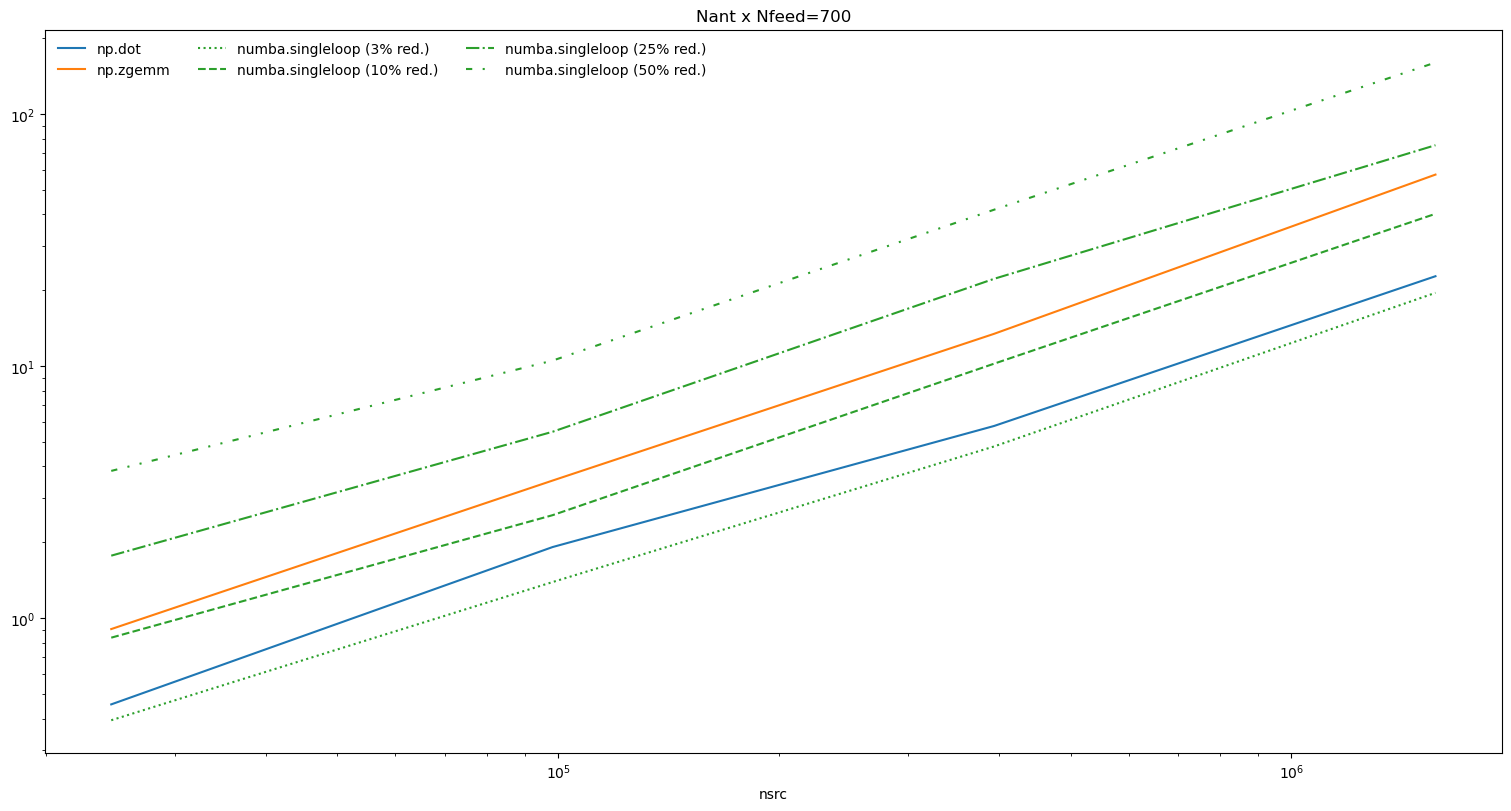

In [155]:
plot_timings_reds(timings_reds, timings);